In [163]:
import os
import madmom
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from datasets import Dataset
from modules.energy_based import simple_energy_onsets
from modules.vis import onset_visualizer, passage_extractor, slur_visualizer
from modules.analysis_funcs import get_segmented_data, get_test_peaks, merging_module, slur_alignment, aubio_peakpicker_do
from sklearn.metrics import confusion_matrix


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [203]:

ds0 = Dataset("initslurtest")
ds1 = Dataset("slurtest_add_1")
ds_test = Dataset("slurtest_test")

audio_fnames = ds_test.get_audio_paths()
label_fnames = ds_test.get_annotation_paths()
audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [np.loadtxt(label_fname, usecols=0) for label_fname in label_fnames]
audio_lengths = [len(audio)/sr for audio, sr in zip(audios, sample_rates)]

/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [204]:
bock = madmom.features.onsets.CNNOnsetProcessor()
pp = madmom.features.onsets.OnsetPeakPickingProcessor(threshold=0.7, combine=0.1)

In [205]:
# CNN method
base_path = "results/cnn-training-220426/"
model_name = "ab-seq-90eps-nostandard-trainable-noextend-dropout0.3"
model = tf.keras.models.load_model(base_path + 'fold_{}_{}_model'.format(0, model_name))

In [206]:
sigg = madmom.audio.signal.SignalProcessor(num_channels=1)
frame = madmom.audio.signal.FramedSignalProcessor(frame_size=256, hop_size=441)
stft = madmom.audio.stft.STFTProcessor()
proc = madmom.processors.SequentialProcessor([sigg, frame, stft])

def get_hfc_onsets(fname, sr):
    hfc = madmom.features.onsets.high_frequency_content(np.abs(proc(fname)))
    onehot, out = aubio_peakpicker_do(hfc, threshold=0.5)
    peaks = (np.where(onehot==1)[0]-5)*441/sr
    return peaks

In [213]:
R = 0

bock_onsets = pp(bock("datasets/slurtest_add/slurtest_add_audio/6xtscale_220306resampled.wav"))

cnn_input = get_segmented_data(audio_fnames[R])
#cnn_input = get_segmented_data("datasets/slurtest_add/slurtest_add_audio/6xtscale_220306resampled.wav")
cnn_output = model.predict(cnn_input)
cnn_onsets = get_test_peaks(cnn_output, 1./100)

hfc_onsets = get_hfc_onsets(audio_fnames[R], sample_rates[R])



/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [214]:
f = open("datasets/slurtest_add/cnn_detections/" + os.path.basename(audio_fnames[R])[:-4] + ".csv", "w")
for i in range(len(cnn_onsets)):
    f.write("{:.3f}".format(cnn_onsets[i])+ "\n")
f.close()

f = open("datasets/slurtest_add/hfc_detections/" + os.path.basename(audio_fnames[R])[:-4] + ".csv", "w")
for i in range(len(hfc_onsets)):
    f.write("{:.3f}".format(hfc_onsets[i])+ "\n")
f.close()

In [215]:
hard_idx, soft_idx = merging_module(bock_onsets, cnn_onsets, tol_sec=0.05)

slur_pred = slur_alignment(hard_idx, soft_idx)
hard_gt, soft_gt = merging_module(
    bock_onsets, # Böck NOD
    onset_schedules[R], # HOD annotations
    tol_sec=0.05
)
slur_true = slur_alignment(hard_gt, soft_gt)

Audio length:  41.29125  s
Segments: [0.0, 8.0, 16.0, 24.0, 32.0, 40.0, 48.0]


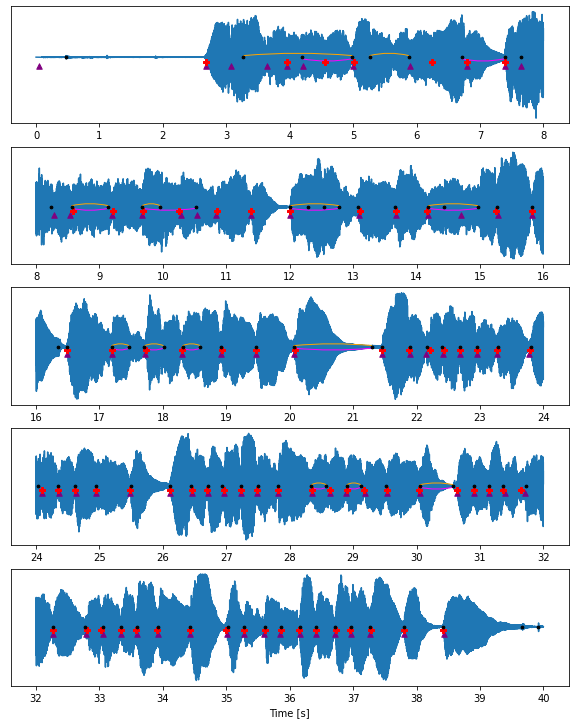

In [216]:

SPP = 8.0 # seconds per plot
print("Audio length: ", audio_lengths[R], " s")
print("Segments:", list(np.arange(0, audio_lengths[R]+SPP, SPP)))
N_PLOTS = int(audio_lengths[R]/SPP)+1
plot_slurs = True

passages = passage_extractor(
    audios[R], 
    [
        bock_onsets,
        onset_schedules[R],
        cnn_onsets,
        #bock_onsets[np.where(slur_pred[:,0]==1)[0]],
        #bock_onsets[np.where(slur_pred[:,1]==1)[0]],
        #bock_onsets[np.where(slur_pred[:,2]==1)[0]],
        #bock_onsets[np.where(slur_pred[:,3]==1)[0]]

        
    ],
    np.arange(0, audio_lengths[R], SPP), 
    sr=sample_rates[R]
)

fig,axs = plt.subplots(len(passages),1, figsize=(10,2.5*len(passages)))
onset_styles = {"m":[
    ".", 
    "P",
    "^", 
    "<", "s", ">", "P"
    ], "c":[
    "k", 
    "r",
    "purple", 
    "magenta", "magenta", "magenta", "magenta"
]}
axs[-1].set_xlabel("Time [s]")

for plot_i, (passage, ax) in enumerate(zip(passages, axs)):
    ax.set_yticks([])
    onset_visualizer(
        passage["audio"], 
        passage["onsets"], 
        (passage["abs_start"], passage["abs_end"]),
        onset_styles=onset_styles,
        ax=ax
        )
    if plot_slurs:
        qual_pred = merging_module(
            passage["onsets"][0], # Böck NOD
            passage["onsets"][2], # CNN HOD
            tol_sec=0.05
        )
        qual_true = merging_module(
            passage["onsets"][0], # Böck NOD
            passage["onsets"][1], # Annotated
            tol_sec=0.05
        )
        slur_pred = slur_alignment(qual_pred[0], qual_pred[1])
        slur_true = slur_alignment(qual_true[0], qual_true[1])
        slur_visualizer(
            passage["onsets"][0],
            slur_pred,
            ax=ax,
            edgecolor="orange",
            sign=0.4
        )
        slur_visualizer(
            passage["onsets"][0],
            slur_true,
            ax=ax,
            edgecolor="magenta",
            sign=-0.4
        )


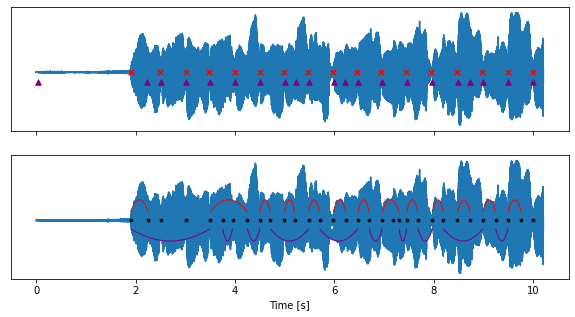

In [94]:
passages = [passage_extractor(
    audios[R], 
    onset_set,
    [0,10.2], 
    sr=sample_rates[R]
)[0] for onset_set in [
    [
        onset_schedules[R],
        cnn_onsets
    ],
    [
        bock_onsets,
    ],
]
]

fig,axs = plt.subplots(len(passages),1, figsize=(10,2.5*len(passages)), sharex=True)
onset_styles = [
    {"m":["x", "^"], "c":["r", "purple"]},
    {"m":["."], "c":["k"]}
]

hard_idx, soft_idx = merging_module(
    passages[1]["onsets"][0], # Böck NOD
    passages[0]["onsets"][1], # CNN HOD
    tol_sec=0.05
)

hard_gt, soft_gt = merging_module(
    passages[1]["onsets"][0], # Böck NOD
    passages[0]["onsets"][0], # HOD annotations
    tol_sec=0.05
)

for plot_i, (passage, ax, onset_style) in enumerate(zip(passages, axs, onset_styles)):
    ax.set_yticks([])
    onset_visualizer(
        passage["audio"], 
        passage["onsets"], 
        (passage["abs_start"], passage["abs_end"]),
        onset_styles=onset_style,
        ax=ax
        )

    if plot_i==1:
        ax.set_xlabel("Time [s]")
        for hard, soft, sign, color in zip(
            [hard_idx, hard_gt],
            [soft_idx, soft_gt],
            [-1,1],
            ["purple", "red"]
        ):
            slur_visualizer(
                passages[1]["onsets"][0],
                slur_alignment(hard, soft),
                ax=ax,
                edgecolor=color,
                sign=sign
            )

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
